<a href="https://colab.research.google.com/github/eyatab/Fundus-images-segmentation-using-Attention-VggUnet3-/blob/main/Attention_VGGUNET3%2B_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#importation

In [ ]:
from skimage.transform import resize
import cv2
import numpy as np
from PIL import Image
import imutils
#from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import keras
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,CSVLogger

from keras.models import Model, load_model
from keras.layers import ReLU
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.activations as activations
import tensorflow.keras.metrics as metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
! pip install tensorflow-addons
import tensorflow_addons.optimizers as optimizers
import tensorflow_addons.losses as losses
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

#functions

##extract disc cup

In [ ]:
def extract_number(filename):
    # Supprimer le "g" initial et convertir le reste en entier
    return int(filename[1:-4])

def extract_disc_and_cup_masks(disc_mask,cup_mask):
   #extract disc
        disc_mask[(disc_mask == 0).all(axis=2)] = [128, 128, 128]  # Gris pour disc
        disc_mask[(disc_mask == 128).all(axis=2)] = [0, 0, 0]
        disc_mask= 255 - disc_mask

        #extract cup
        cup_mask[(cup_mask == 128).all(axis=2)] = [255, 255, 255]  # Blanc pour cup
        cup_mask = 255 - cup_mask
        # Apply thresholding to create a binary mask disc
        disc_mask = cv2.cvtColor(disc_mask, cv2.COLOR_BGR2GRAY)
        #_, disc_mask = cv2.threshold(disc_mask, 128, 255, cv2.THRESH_BINARY)
        # Apply thresholding to create a binary mask cup
        cup_mask= cv2.cvtColor(cup_mask, cv2.COLOR_BGR2GRAY)
        _, cup_mask = cv2.threshold(cup_mask, 1, 255, cv2.THRESH_BINARY)

        # Taille cible finale
        target_size = (256, 256)

        # Effectuer une réduction progressive en plusieurs étapes
        while disc_mask.shape[0] > target_size[0] or disc_mask.shape[1] > target_size[1]:
              # Réduire l'image de moitié à chaque étape
              disc_mask = cv2.resize(disc_mask, (max(disc_mask.shape[1] // 2, target_size[1]), max(disc_mask.shape[0] // 2, target_size[0])))

        # Redimensionner l'image à la taille finale
              disc_mask= cv2.resize(disc_mask, target_size,cv2.INTER_AREA)

        # Effectuer une réduction progressive en plusieurs étapes
        while cup_mask.shape[0] > target_size[0] or cup_mask.shape[1] > target_size[1]:
        # Réduire l'image de moitié à chaque étape
              cup_mask = cv2.resize(cup_mask, (max(cup_mask.shape[1] // 2, target_size[1]), max(cup_mask.shape[0] // 2, target_size[0])))

        # Redimensionner l'image à la taille finale
              cup_mask= cv2.resize(cup_mask, target_size,cv2.INTER_AREA)

        #disc_mask = cv2.resize(disc_mask, (256, 256),interpolation=cv2.INTER_NEAREST)
        #cup_mask = cv2.resize(cup_mask, (256, 256),interpolation=cv2.INTER_NEAREST)

        return disc_mask, cup_mask

##readimg

In [ ]:
def readimg(img):
  img = cv2.resize(img, (256, 256))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

##fct_attention

In [ ]:
def channel_attention(input_feature, ratio=8):

	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

	avg_pool = GlobalAveragePooling2D()(input_feature)
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)

	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)

	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7

	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature

	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature.shape[-1] == 1

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])


##cbam

In [ ]:
def cbam_block(cbam_feature, ratio=8):
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature


#Train data

In [ ]:
Path_trainGT='/content/drive/MyDrive/REFUGE/train/gts'
Path_trainIMG='/content/drive/MyDrive/REFUGE/train/Images'


image_files = os.listdir(Path_trainIMG) #nom files
# Trier les noms de fichiers en utilisant la fonction de tri personnalisée
image_files = sorted(image_files, key=extract_number)

# Initialize lists to store training data and labels
training_images = []
training_GTOD= []

for image_file in image_files:
    image_path = os.path.join(Path_trainIMG, image_file)
    gt_file = os.path.splitext(image_file)[0] + '.bmp'
    gt_path = os.path.join(Path_trainGT, gt_file)

    if os.path.isfile(gt_path):
        # Charger l'image et ground truth
        image = cv2.imread(image_path)
        gt = cv2.imread(gt_path)
        #create copy
        disc_mask = gt.copy()
        cup_mask = gt.copy()
        image= readimg(image)

        disc_mask, cup_mask = extract_disc_and_cup_masks(disc_mask, cup_mask)
        # Remodeler training_GTOD en (256, 256, 1)
        disc_mask= np.reshape(disc_mask, (256, 256, 1))
        # Vérification : imprimer un message de débogage pour chaque image traitée


        # Ajouter les données chargées aux listes
        training_images.append(image)
        training_GTOD.append(disc_mask)


# Convertir les listes en tableaux NumPy pour une manipulation plus facile
training_images= np.array(training_images)
training_GTOD = np.array(training_GTOD)


#validation data

In [ ]:
Path_valGT='/content/drive/MyDrive/REFUGE/val/gts'
Path_valIMG='/content/drive/MyDrive/REFUGE/val/Images'

#Path_valGT='/content/drive/MyDrive/File isg/REFUGE/val/gts'
#Path_valIMG='/content/drive/MyDrive/File isg/REFUGE/val/Images'

image_files = os.listdir(Path_valIMG) #nom files
# Trier les noms de fichiers en utilisant la fonction de tri personnalisée
image_files = sorted(image_files, key=extract_number)
#print(image_files )
# Initialize lists to store training data and labels
val_images = []
val_GTOD= []

for image_file in image_files:
    image_path = os.path.join(Path_valIMG, image_file)
    gt_file = os.path.splitext(image_file)[0] + '.bmp'  # Correction de l'extension à '.bmp'
    gt_path = os.path.join(Path_valGT, gt_file)

    if os.path.isfile(gt_path):
        # Charger l'image et ground truth
        image = cv2.imread(image_path)
        gt = cv2.imread(gt_path)
        #create copy
        disc_mask = gt.copy()
        cup_mask = gt.copy()
        image= readimg(image)
        disc_mask, cup_mask = extract_disc_and_cup_masks(disc_mask, cup_mask)

        disc_mask= np.reshape(disc_mask, (256, 256, 1))

        val_images.append(image)
        val_GTOD.append(disc_mask)


# Convertir les listes en tableaux NumPy pour une manipulation plus facile
val_images = np.array(val_images)
val_GTOD = np.array(val_GTOD)


In [ ]:
print(val_images.shape)

(120, 256, 256, 3)


#normalization

In [ ]:
training_images= training_images / 255.0
training_GTOD= training_GTOD / 255.0


val_images= val_images / 255.0
val_GTOD= val_GTOD / 255.0



#architecture modele

##disc

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, UpSampling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint

# Defining the decoder's up-sampling blocks.
def upscale_blocks(inputs):
    n_upscales = len(inputs)
    upscale_layers = []

    for i, inp in enumerate(inputs):
        p = n_upscales - i
        u = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2**p, padding='same')(inp)

        for i in range(2):
            u = layers.Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(u)
            u = layers.BatchNormalization()(u)
            u = layers.Activation(activations.relu)(u)
            u = layers.Dropout(rate=0.4)(u)

        upscale_layers.append(u)
    return upscale_layers
# Définition des blocs de décodeur
def decoder_block(layers_to_upscale, inputs):
    # Upsample layers_to_upscale pour qu'elles aient les mêmes dimensions que les entrées du décodeur
    upscaled_layers = []
    for i, inp in enumerate(inputs):
      if i < len(layers_to_upscale):
        upscale_factor = int(inputs[0].shape[1]) // int(layers_to_upscale[i].shape[1])
        upsampled = layers.UpSampling2D(size=(upscale_factor, upscale_factor))(layers_to_upscale[i])
        upscaled_layers.append(upsampled)


        d = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', use_bias=False)(inp)
        d = layers.BatchNormalization()(d)
        d = layers.Activation(relu)(d)
        d = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', use_bias=False)(d)
        d = layers.BatchNormalization()(d)
        d = layers.Activation(relu)(d)

        upscaled_layers.append(d)

    decoder = layers.concatenate(upscaled_layers)
    decoder = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', use_bias=False)(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation(relu)(decoder)
    decoder = layers.Dropout(rate=0.4)(decoder)

    return decoder

def get_model(input_dim):
    inputs = Input(input_dim)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_dim)
    base_model.trainable = False
    # Récupérez la sortie de l'encodeur (la dernière couche de convolution)
    x = base_model.output

    # Decoder blocks for optic disc segmentation (modified)
    d4 = decoder_block(layers_to_upscale=[x], inputs=[base_model.input])
    d3 = decoder_block(layers_to_upscale=[x, d4], inputs=[base_model.input])
    d2 = decoder_block(layers_to_upscale=[x, d4, d3], inputs=[base_model.input])
    d1 = decoder_block(layers_to_upscale=[x, d4, d3, d2], inputs=[base_model.input])
    d1 =  cbam_block(d1)
    # Output layer for optic disc segmentation
    disc_output = layers.Conv2D(filters=1, kernel_size=1, padding='same', activation='sigmoid')(d1)

    model = models.Model(inputs=base_model.input, outputs=disc_output)

    return model

disc_model = get_model((256, 256, 3))


#compile model

In [ ]:
from tensorflow.keras.metrics import Accuracy
%cd /content/drive/MyDrive
checkpoint_path = "/content/drive/MyDrive/disc_bestvggrgbatt40.h5"
# Créez un callback pour sauvegarder les poids du modèle.
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                            save_weights_only=True,
                                            verbose=1,
                                            save_best_only=True)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),#réduire LR pendant l'entraînement lorsque la métrique spécifiée cesse de s'améliorer
    model_checkpoint_callback,
    CSVLogger("/content/drive/MyDrive/disc_metrvggatt.csv"),#enregistre les métriques d'entraînement dans un fichier CSV.
]


/content/drive/MyDrive


In [ ]:
disc_model = get_model((256, 256, 3))
#print("Logits shape:", model.output_shape)
#print("Labels shape:", training_GTOD.shape)

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
disc_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=["accuracy",tf.keras.metrics.MeanIoU(num_classes=2)]
)
results = disc_model.fit(training_images, training_GTOD, batch_size= 4, epochs=40,validation_data=(val_images, val_GTOD),callbacks=callbacks)

In [ ]:
#model.save('modeldisc.h5')
val_loss=results.history['val_loss']

#visualization

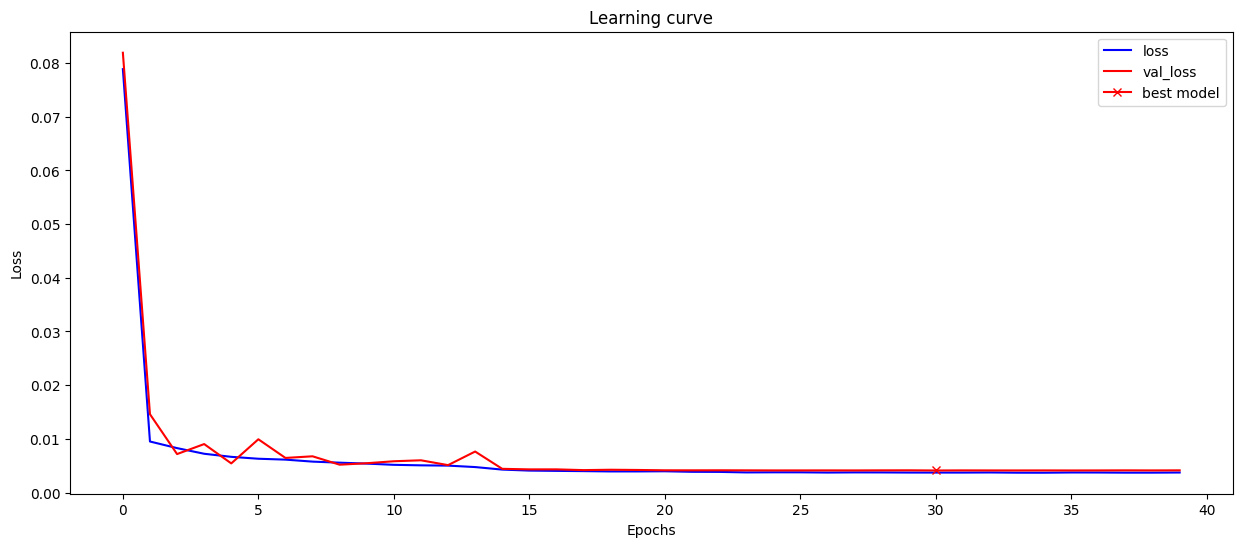

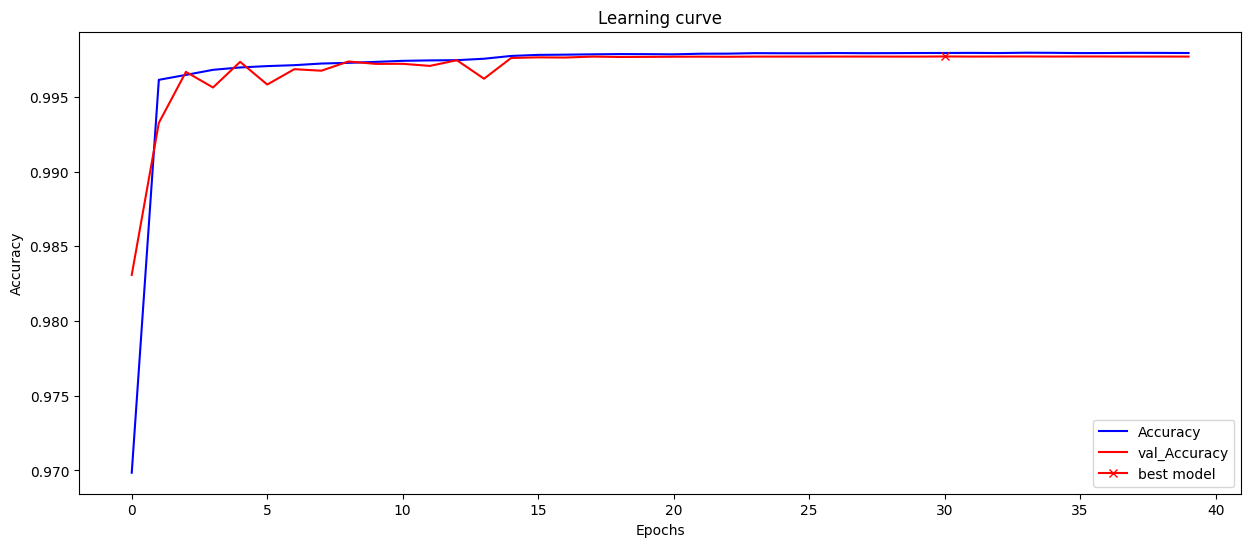

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color="b")
plt.plot(results.history["val_loss"], label="val_loss", color="r")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy", color="b")
plt.plot(results.history["val_accuracy"], label="val_Accuracy", color="r")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();